In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
np.random.seed()
import time
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras import optimizers
import keras.backend as K

import sklearn
from sklearn.utils import check_array
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
import tensorflow as tf

## (1.) Loading data to python

In [5]:
dataset = pd.read_csv('Dataset.csv', index_col=0 )
dataset.head()

,AMSTEOE,DAXINDX,FRCAC40,FTSE100,HNGKNGI,PDOWA,GALLS,COMP
0,261.36,1411.28,1482.89,2371.0,3225.97,23755.89,387.17,307.52
1,262.02,1419.76,1490.42,2382.0,3207.21,24102.98,391.44,308.37
2,263.32,1431.03,1490.42,2386.6,3216.11,24118.01,393.99,307.63
3,264.98,1440.47,1490.42,2403.0,3253.42,23931.52,390.23,310.68
4,264.50,1462.16,1490.42,2419.2,3262.30,23969.76,395.71,310.42


In [6]:
dataset.shape

(2734, 8)

### Plotting the stock indices

In this section we will plot our 8 different stock indices. Each stock index represents a stock trading on a certain stock market.

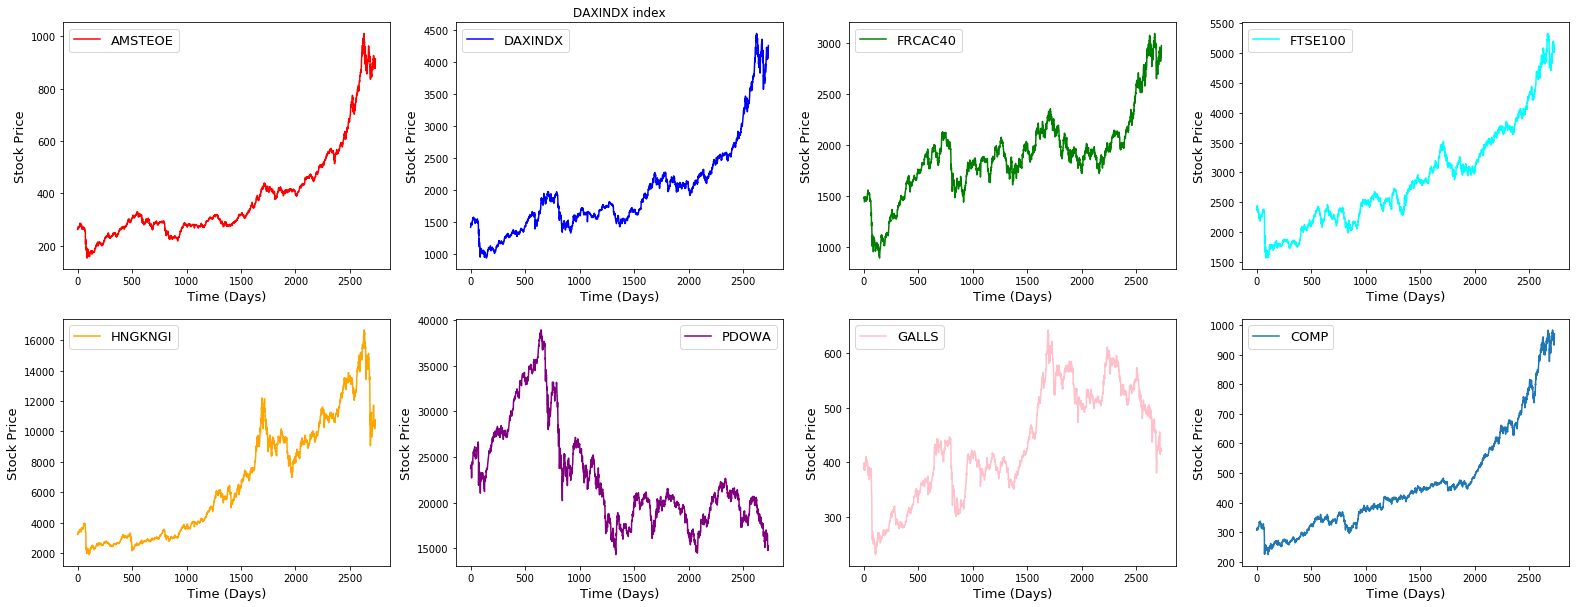

In [7]:
fig = plt.figure(figsize=(27,10))

#Plotting figure for AMSTEOE Index
fig.add_subplot(2,4,1)
plt.plot(dataset['AMSTEOE'].values, label = 'AMSTEOE', color = 'red')
#plt.title('AMSTEOE index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for DAXINDX Index
fig.add_subplot(2,4,2)
plt.plot(dataset['DAXINDX'], label = 'DAXINDX', color = 'blue')
plt.title('DAXINDX index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for FRCAC40 Index
fig.add_subplot(2,4,3)
plt.plot(dataset['FRCAC40'], label = 'FRCAC40', color = 'green')
#plt.title('FRCAC40 index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for FTSE100 Index
fig.add_subplot(2,4,4)
plt.plot(dataset['FTSE100'], label = 'FTSE100', color = 'cyan')
#plt.title('FTSE100 index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for HNGKNGI Index
fig.add_subplot(2,4,5)
plt.plot(dataset['HNGKNGI'], label = 'HNGKNGI', color = 'orange')
#plt.title('HNGKNGI index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for PDOWAIndex
fig.add_subplot(2,4,6)
plt.plot(dataset['PDOWA'], label = 'PDOWA', color = 'purple')
#plt.title('PDOWA index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for GALLS Index
fig.add_subplot(2,4,7)
plt.plot(dataset['GALLS'], label = 'GALLS', color = 'pink')
#plt.title('GALLS index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

#Plotting figure for COMP Index
fig.add_subplot(2,4,8)
plt.plot(dataset['COMP'], label = 'COMP')
#plt.title('COMP index')
plt.xlabel('Time (Days)', fontsize = 13)
plt.ylabel('Stock Price', fontsize = 13)
plt.legend(fontsize = 13)

plt.show()

### Dataset consisting of only predictors (Feutures)

We will use all the stock indices to predict AMSTEOE stock index.

In [8]:
stock_dataset = dataset
stock_dataset.head()
data1 = stock_dataset[['AMSTEOE']]
data1.head()

,AMSTEOE
0,261.36
1,262.02
2,263.32
3,264.98
4,264.50


In [9]:
print('the shape of the predicting dataset is ', stock_dataset.shape)

the shape of the predicting dataset is  (2734, 8)


## (2.) Data setup for Input to RNN's

### Normalizing the data

We will normalize our data to values between 0 and 1 using the python's MinMaxScaler function. 

In [10]:
def normaliser(data,frange =(0,1)):
    #normaliser feutures
    scaler = MinMaxScaler(feature_range=frange)
    dt = data.values
    #dt = dt.reshape(-1,1)
    scaled = scaler.fit_transform(dt)
    return scaled, scaler

In [11]:
#normalised_prices = normaliser(stock_dataset)

In [12]:
scaler1 = MinMaxScaler(feature_range = (0,1))
scaler2 = MinMaxScaler(feature_range = (0,1))
normalised_prices = scaler1.fit_transform(stock_dataset.values)
#prices_n = scaler2.fit_transform(stock_dataset[:].values)
normalised_prices[0:5] #Taking a look at our normalized values
n = scaler2.fit_transform(data1)

### Transforming the time series into well labelled training and testing dataset 

We will use the following function to transform time series into well labelled braining training and target samples. i.e we transform out input into a tuple (n_samples,n_timesteps,n_features)

In [13]:
def rnn_data_setup(data, lookback, delay, min_index, max_index):
    '''
    data:     Shape (n_samples,n_features). First column is the time series, other columns are the features.
    lookback: Number of time steps in the RNN >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x,y) of numpy arrays where x is in shape (n_samples,n_timesteps,n_features) and 
             y is in shape (n_samples,delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    '''
    n_samples=(max_index+1)-min_index-(lookback-1)-delay
    samples = np.zeros((n_samples,lookback,data.shape[-1]))
    targets = np.zeros((n_samples,delay))
                  
    samp, targ = [], []
    for i in range(n_samples):  
        indices1 = range(i, i+lookback)
        indices2 = range(i + lookback, i + lookback + delay)
        samples[i] = data[indices1]
        targets[i,:] = data[indices2][0:delay][:,0] 
        #print(samples,targets)
    samp.append(samples);targ.append(targets)

    return np.array(samp)[0],np.array(targ)[0]

In [36]:
lookback =1
look_back = 10
delay = 1
min_index = 0
max_index = 2733
xdata, ydata = rnn_data_setup(normalised_prices, lookback, delay, min_index, max_index)
print('The shape of the input sample set is: ',  xdata.shape)
print('The shape of the target set is: ', ydata.shape)

The shape of the input sample set is:  (2733, 1, 8)
The shape of the target set is:  (2733, 1)


### Splitting the dataset into the training and testing sets

We are splitting the dataset of normalized stock prices into 80$\%$ and 20$\%$ for training and testing respectively. 20 $\%$ of training set will be assigned for validation at later stage.

In [15]:
#Specifying the sizes of training and testing datasets.
train_size = int(len(xdata)*0.6)
valid_size = int(len(xdata)*0.2)
test_size = len(xdata) - train_size-valid_size

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (1639, 1, 8)
The shape of the validation sample is:  (546, 1, 8)
The shape of the testing sample is:  (548, 1, 8)
The shape of the training target is:  (1639, 1)
The shape of the validation target is:  (546, 1)
The shape of the testing target is:  (548, 1)


In [16]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))

## Recurrent Neural Networks Models

## (A.) SimpleRNN model 

We will be are looking the best RNN model by looking the model's performance according to different variations in terms of its variables.  

#### Input variables

In [22]:
n_features = 8
lr = 0.0012#Learning rate
units = 16 #Number hidden units
batch_size=512

In [23]:
#define the model
model1 = Sequential()
model1.add(keras.layers.SimpleRNN(units, activation = 'linear', input_shape = (lookback, n_features), return_sequences =False))
#model1.add(Dropout(0.2))
model1.add(Dense(1))
opt = adam(lr)#, decay=1e-6)
model1.compile(optimizer = 'adam' , loss = 'mse', metrics=["mae"])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 16)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


### (i.) Fitting the model

In [24]:
np.random.seed(1)
result1=model1.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=100, verbose=0)

In [25]:
df = pd.DataFrame(result1.history)
df.tail()

,val_loss,val_mean_absolute_error,loss,mean_absolute_error
95,0.000046,0.006028,0.000015,0.002929
96,0.000013,0.002760,0.000014,0.002727
97,0.000036,0.005237,0.000012,0.002409
98,0.000017,0.003331,0.000015,0.002806
99,0.000084,0.008535,0.000013,0.002560


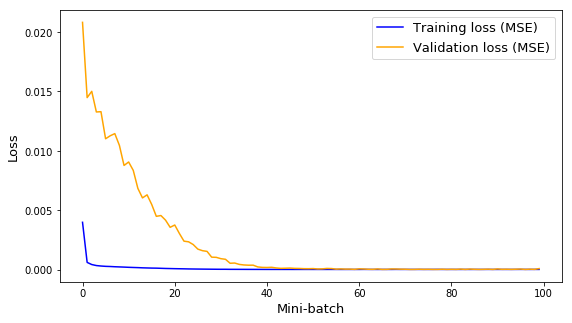

In [26]:
print('')
plt.figure(figsize=(9,5))
plt.plot(df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_error1.eps', format='eps', dpi=1000)
plt.show()

### (ii.) Predictions

Now we will use our model to make predictions.

In [27]:
preds1 = model1.predict(xtest)
preds1.shape


(548, 1)

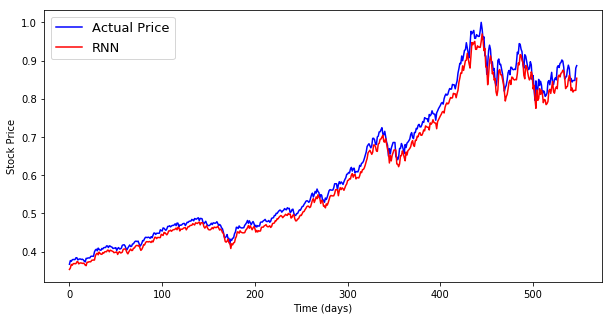

In [28]:
print('')
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds1, label="RNN", color = 'red')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.legend(fontsize=13)
plt.show()

In [29]:
#actuals = scaler2.inverse_transform(xtest)
real_pred1 = scaler2.inverse_transform(preds1)

In [30]:
ytest=ytest.reshape(-1, 1)
actuals = scaler2.inverse_transform(ytest)

#### Plot of Actual Stock Prices

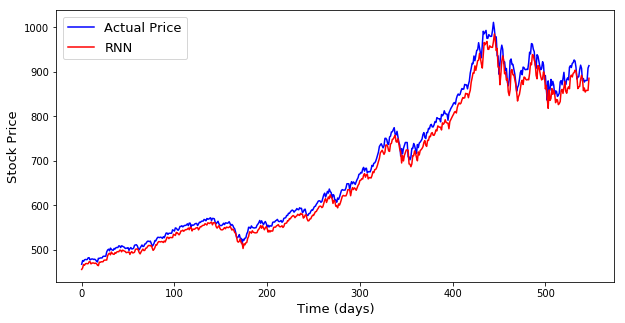

In [93]:
print('')
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Price", color = 'blue')
plt.plot(real_pred1, label="RNN", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_model1.eps', format='eps', dpi=1000)
plt.show()

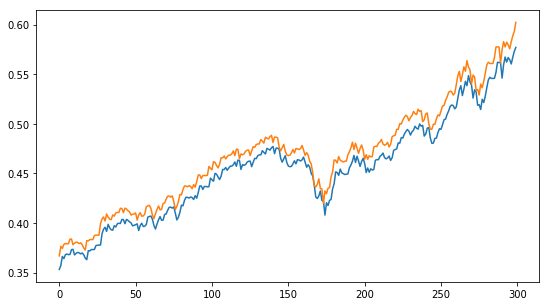

In [32]:
plt.figure(figsize=(9,5))
plt.plot(preds1[:300,:])
plt.plot(ytest[:300,:])
plt.show()

### (iii.) RNN Model MSE

In [33]:
print('The the mean squared error committed by the standard RNN model is ', mean_squared_error(actuals,real_pred1))
print('The squaroot of the mean squared error committed by the standard RNN model is ', np.sqrt(mean_squared_error(actuals,real_pred1)))

The the mean squared error committed by the standard RNN model is  351.49269597718717
The squaroot of the mean squared error committed by the standard RNN model is  18.74813846698352


### (iv.) RNN Model MAPE

In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_pred)) * 100

In [35]:
print('The the mean absolute percentage error committed by the standard RNN model is: ', mean_absolute_percentage_error(actuals,real_pred1))

The the mean absolute percentage error committed by the standard RNN model is:  2.333324181787325


### (v.) RNN Model MAE

In [37]:
print('The the mean absolute error committed by the standard RNN model is: ', mean_absolute_error(actuals,real_pred1))

The the mean absolute error committed by the standard RNN model is:  15.989171592545341


## (B.) LSTM Model

In [48]:
# Define the LSTM model
model2 = Sequential()
model2.add(LSTM(32, activation='linear', input_shape = (lookback,8), return_sequences = True))
#model2.add(LSTM(32, return_sequences = True))
#model2.add(Dropout(0.5))
model2.add(LSTM(32))
#model2.add(Dropout(0.5))
model2.add(Dense(1))
opt = adam(lr=0.01)#, decay=1e-6)
model2.compile(loss='mse', optimizer=opt , metrics=["mae"])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 32)             5248      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________


### (i.) Fitting the model

In [49]:
n_epochs =150
valid_score = 0.2
start = time.time()
np.random.seed(1)
result2=model2.fit(xtrain,ytrain,batch_size=300,nb_epoch=n_epochs,validation_split=valid_score, verbose = 0)
print("> Compilation Time : ", time.time() - start)

/Users/naftalindeapo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


> Compilation Time :  8.534209966659546


In [50]:
df2 = pd.DataFrame(result2.history)
df2.tail()

,val_loss,val_mean_absolute_error,loss,mean_absolute_error
145,0.000018,0.003574,0.000014,0.002602
146,0.000010,0.002451,0.000013,0.002574
147,0.000008,0.002229,0.000013,0.002524
148,0.000011,0.002489,0.000012,0.002401
149,0.000008,0.002147,0.000017,0.003037


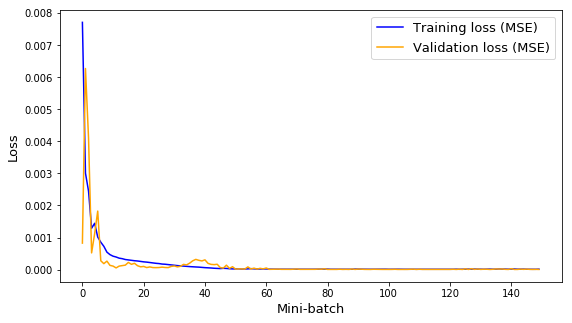

In [92]:
plt.figure(figsize=(9,5))
plt.plot(df2['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(df2['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('LSTM1_error.eps', format='eps', dpi=1000)
plt.show()

### (ii.) Predictions

In [52]:
# Doing a prediction on all the test data at once
preds2 = model2.predict(xtest)

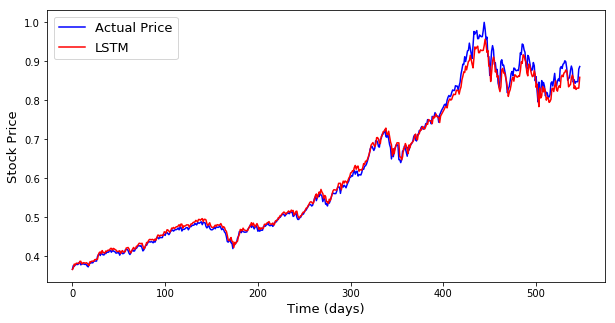

In [53]:
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds2, label="LSTM", color = 'red')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [54]:
real_pred2 = scaler2.inverse_transform(preds2)

#### Plot of Actual Stock Prices

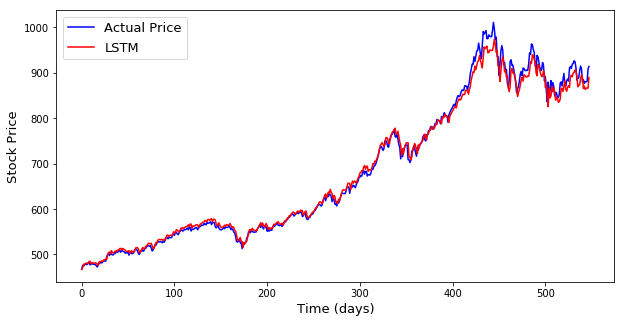

In [91]:
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Price", color = 'blue')
plt.plot(real_pred2, label="LSTM", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('LSTM_model1.eps', format='eps', dpi=1000)
plt.show()

### (iii.) LSTM Model MSE

In [56]:
print('The the mean squared error committed by the LSTM model is ', mean_squared_error(actuals,real_pred2))
print('The squareroot of the mean squared error committed by the LSTM model is ', np.sqrt(mean_squared_error(actuals,real_pred2)))

The the mean squared error committed by the LSTM model is  180.3062766415885
The squareroot of the mean squared error committed by the LSTM model is  13.427817270189095


### (iv.) LSTM Model MAPE

In [57]:
print('The the mean squared error committed by the  model is: ', mean_absolute_percentage_error(actuals,real_pred2))

The the mean squared error committed by the  model is:  1.2444393115055028


### (v.) RNN MAE

In [58]:
print('The the mean absolute error committed by the standard RNN model is: ', mean_absolute_error(actuals,real_pred2))

The the mean absolute error committed by the standard RNN model is:  9.26822653443274


## (C.) GRU Model

In [65]:
n_features = 8
# define model
model3 = Sequential()
model3.add(keras.layers.GRU(128, activation='relu', input_shape=(lookback, n_features)))
model3.add(Dropout(0.1801))
model3.add(Dense(1))
opt = keras.optimizers.Adam(lr=0.0114)
model3.compile(optimizer = opt, loss='mse', metrics=["mae"])
model3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 128)               52608     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 52,737
Trainable params: 52,737
Non-trainable params: 0
_________________________________________________________________


### (i.) Fitting the model

In [66]:
n_epochs = 150
valid_score = 0.2
start = time.time()
result3 = model3.fit(xtrain,ytrain,batch_size=200,nb_epoch=n_epochs,validation_split=valid_score, verbose = 0)
model3.reset_states()
print("> Compilation Time : ", time.time() - start)

/Users/naftalindeapo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


> Compilation Time :  9.140645027160645


In [67]:
df3 = pd.DataFrame(result3.history)
df3.tail()

,val_loss,val_mean_absolute_error,loss,mean_absolute_error
145,0.000010,0.002432,0.000136,0.008971
146,0.000010,0.002513,0.000138,0.009004
147,0.000022,0.003698,0.000134,0.008758
148,0.000012,0.002607,0.000135,0.008842
149,0.000012,0.002822,0.000130,0.008636


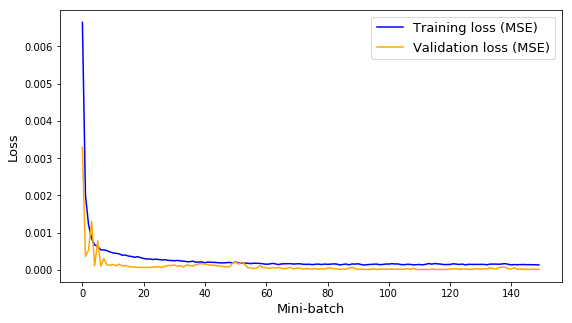

In [98]:
print('')
plt.figure(figsize=(9,5))
plt.plot(df3['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(df3['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('GRU1_error.eps', format='eps', dpi=1000)
plt.show()

### (ii.) Predictions

In [69]:
preds3 = model3.predict(xtest)

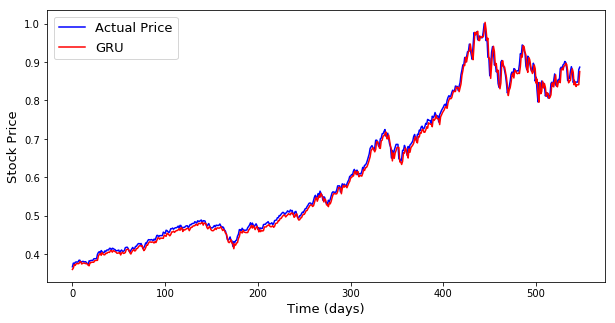

In [70]:
print('')
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds3, label="GRU", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [71]:
real_pred3 = scaler2.inverse_transform(preds3)

#### Plot of Actual Stock Prices

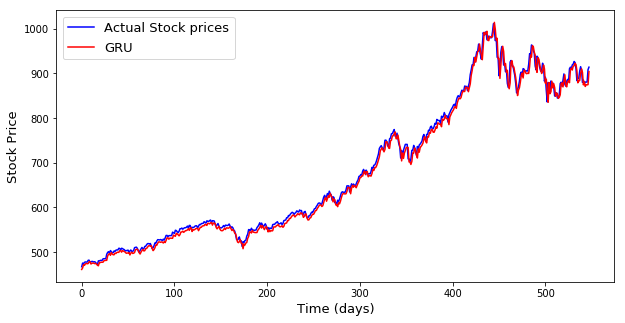

In [97]:
print('')
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Stock prices", color = 'blue')
plt.plot(real_pred3, label="GRU", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('GRU_model1.eps', format='eps', dpi=1000)
plt.show()

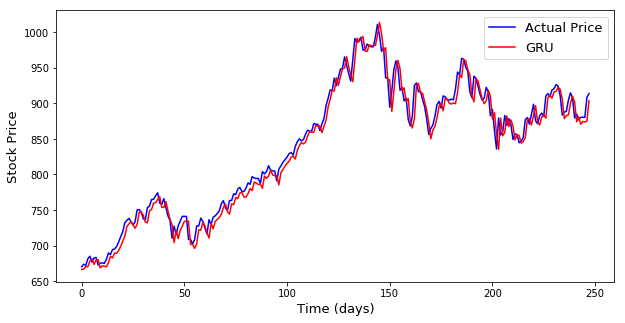

In [73]:
plt.figure(figsize=(10,5))
plt.plot(actuals[300:], label="Actual Price", color = 'blue')
plt.plot(real_pred3[300:], label="GRU", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

### (iii.) GRU Model MSE

In [74]:
print('The the mean squared error committed by the GRU model is ', mean_squared_error(actuals,real_pred3))
print('The squareroot of the mean squared error committed by the GRU model is ', np.sqrt(mean_squared_error(actuals,real_pred3)))

The the mean squared error committed by the GRU model is  117.17993171975513
The squareroot of the mean squared error committed by the GRU model is  10.824967977770426


### (iv.) GRU Model MAPE

In [75]:
print('The the mean absolute percentage error committed by the GRU model is: ', mean_absolute_percentage_error(actuals,real_pred3))

The the mean absolute percentage error committed by the GRU model is:  1.2196182383854344


 ### (v.) GRU MAE

In [76]:
print('The the mean absolute error committed by the standard RNN model is: ', mean_absolute_error(actuals,real_pred3))

The the mean absolute error committed by the standard RNN model is:  8.382666472274895


## (D.) Combined Models

### Predicted Prices

In [77]:
Pred_Data=pd.DataFrame({'RNN':real_pred1[:,0],'LSTM':real_pred2[:,0],'GRU':real_pred3[:,0], 'Actual Price':actuals[:,0]})
Pred_Data.head()

,RNN,LSTM,GRU,Actual Price
0,455.649567,466.907471,461.324585,467.37
1,459.016815,470.622803,464.594910,475.62
2,466.862061,478.813629,472.159515,473.85
3,465.065704,476.627625,470.430695,477.22
4,468.354095,480.367920,473.838470,478.11


In [78]:
#saving dataset of predicted prices
Pred_Data.to_csv('Pred_Data1.csv', sep = ',', header = True)

### Combined Plots

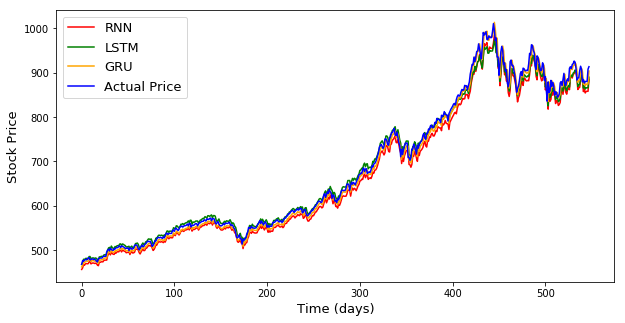

In [89]:
plt.figure(figsize=(10,5))
plt.plot(Pred_Data['RNN'], color = 'red')
plt.plot(Pred_Data['LSTM'], color = 'green')
plt.plot(Pred_Data['GRU'], color = 'orange')
plt.plot(actuals, color = 'blue', label = 'Actual Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('Combined1.eps', format='eps', dpi=1000)
plt.show()

## (E.) Average of the three models

In [80]:
predmean1=pd.DataFrame({'RNN':real_pred1[:,0],'LSTM':real_pred2[:,0],'GRU':real_pred3[:,0]}).mean(axis=1)
predmean1.head()

0    461.293854
1    464.744873
2    472.611725
3    470.708008
4    474.186859
dtype: float32

In [81]:
predmean1.to_csv('Average1.csv', sep = ',', header = True)

### Plot of the  Average of the 3 Models against the actual prices

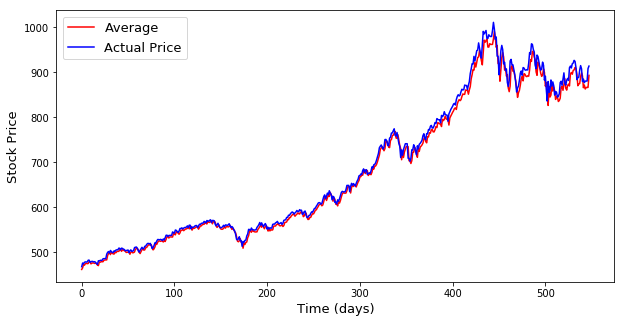

In [88]:
plt.figure(figsize=(10,5))
plt.plot(predmean1, color = 'red', label = 'Average')
plt.plot(actuals, color = 'blue', label = 'Actual Price')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('Average1.eps', format='eps', dpi=1000)
plt.show()

### Average Mean absolute Error (MSE)

In [96]:
print('The the mean squared error committed by the average model is ', mean_squared_error(actuals,predmean1))
print('The squareroot of the mean squared error committed by the average model is ', np.sqrt(mean_squared_error(actuals,predmean1)))

The the mean squared error committed by the average model is  157.2087265303739
The squareroot of the mean squared error committed by the average model is  12.538290414979782


### Average Mean Absolute Percentage Error (MAPE)

In [87]:
print('The the mean absolute percentage error committed by the average of the 3 models is: ', mean_absolute_percentage_error(actuals,predmean1)/23)

The the mean absolute percentage error committed by the average of the 3 models is:  1.1656227102697105


In [95]:
print('The the mean absolute error committed by the average model is: ', mean_absolute_error(actuals,predmean1))

The the mean absolute error committed by the average model is:  9.128420020333179
